**Paste the row from the document here**

In [ ]:
#Paste here

In [ ]:
import json
file_path = '/content/kaggle.json'

data = json.loads(details)

with open(file_path, 'w') as json_file:
    json.dump(data, json_file)

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [ ]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [ ]:
!pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install scipy

In [ ]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 3.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

import random
from random import sample
import shutil
import os

from matplotlib.image import imread
from PIL import Image
from scipy import ndimage

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns

2023-07-17 17:50:11.242930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 17:50:11.910651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## Load the data

In [ ]:
# Get the path of the directories
def get_dir_path(main_dir='',sub_dir='',class_name=''):
  dir = os.path.join(os.getcwd(), main_dir)
  if sub_dir!='':
    dir=os.path.join(dir, sub_dir)
  if class_name!='':
    dir=os.path.join(dir, class_name)
  return dir

train_dir=get_dir_path('chest_xray','train')
val_dir=get_dir_path('chest_xray','val')
test_dir=get_dir_path('chest_xray','test')

In [ ]:
# Create dataframe with files paths and labels
def create_df(dir):
  filepaths = []
  labels = []

  folds = os.listdir(dir)
  for fold in folds:
      foldpath = os.path.join(dir, fold)
      filelist = os.listdir(foldpath)
      for file in filelist:
          fpath = os.path.join(foldpath, file)
          filepaths.append(fpath)
          label="NORMAL"
          if "bacteria" in file:
            label="BACTERIA"
          elif "virus" in file:
            label="VIRUS"
          labels.append(label)

  # Concatenate data paths with labels into one dataframe
  Fseries = pd.Series(filepaths, name= 'filepath')
  Lseries = pd.Series(labels, name='target')
  df = pd.concat([Fseries, Lseries], axis= 1)
  return df

train_df=create_df(train_dir)
val_df=create_df(val_dir)
test_df=create_df(test_dir)

print(f'There are {len(train_df)} in train set')
print(f'There are {len(val_df)} in validation set')
print(f'There are {len(test_df)} in test set')

There are 5216 in train set
There are 16 in validation set
There are 624 in test set


In [ ]:
train_df.head()

,filepath,target
0,/raid/shelly_daniela/chest_xray/train/NORMAL/I...,NORMAL
1,/raid/shelly_daniela/chest_xray/train/NORMAL/I...,NORMAL
2,/raid/shelly_daniela/chest_xray/train/NORMAL/I...,NORMAL
3,/raid/shelly_daniela/chest_xray/train/NORMAL/I...,NORMAL
4,/raid/shelly_daniela/chest_xray/train/NORMAL/I...,NORMAL


In [ ]:
# Show the number of images of each label in each dataset (train/validation/test)
def show_classes_counts(train_df,val_df,test_df):
  # Counts the occurrences of each class in the target column of each df
  train_counts = train_df['target'].value_counts().reindex(['BACTERIA','VIRUS' ,'NORMAL'])
  val_counts = val_df['target'].value_counts().reindex(['BACTERIA','VIRUS' ,'NORMAL'])
  test_counts = test_df['target'].value_counts().reindex(['BACTERIA','VIRUS' ,'NORMAL'])

  # Creates a bar plot to show the counts for each DataFrame
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
  train_counts.plot(kind='bar', ax=axes[0], color=['blue','green', 'orange'])
  val_counts.plot(kind='bar', ax=axes[1], color=['blue','green', 'orange'])
  test_counts.plot(kind='bar', ax=axes[2], color=['blue','green', 'orange'])

  # Adds y-value (count) labels to each bar
  for ax in axes:
      for p in ax.containers:
          ax.bar_label(p, label_type='edge')

  axes[0].set_title(f'Train - {len(train_df)} images')
  axes[1].set_title(f'Validation - {len(val_df)} images')
  axes[2].set_title(f'Test - {len(test_df)} images')
  plt.tight_layout()
  plt.show()

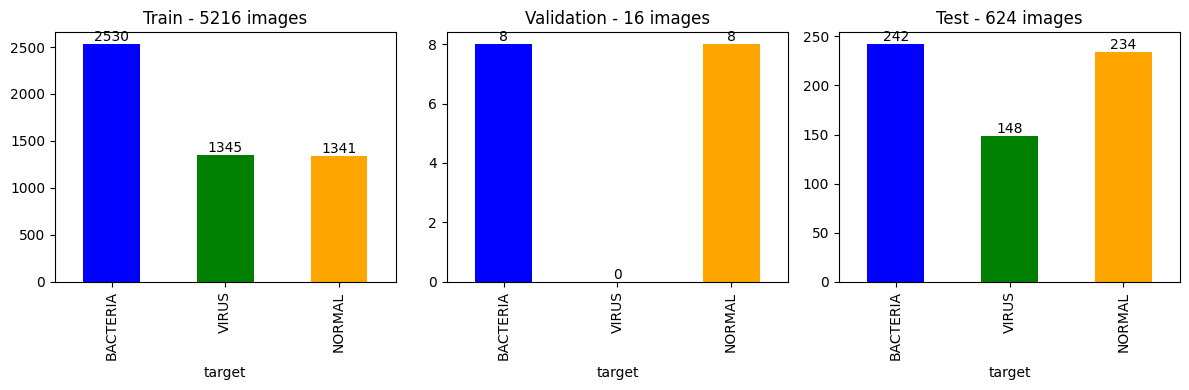

In [ ]:
show_classes_counts(train_df,val_df,test_df)

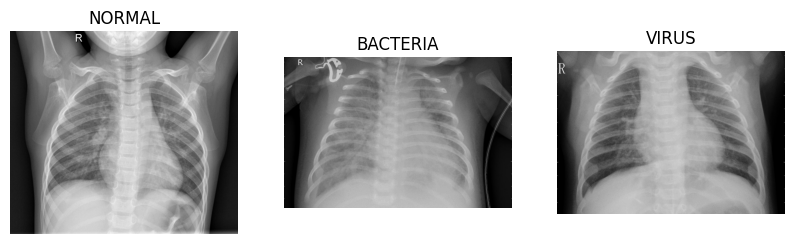

In [ ]:
# Show images for each label
unique_targets = train_df.target.unique()
num_images = len(unique_targets)

fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 5))

for i, ax in enumerate(axes):
    target = unique_targets[i]
    example_image_path = train_df[train_df['target'] == target]['filepath'].iloc[0]
    example_image = imread(example_image_path)

    ax.imshow(example_image, cmap='gray')
    ax.set_title(target)
    ax.axis('off')

plt.show()



## Increase validation set

In [ ]:
# Define the number of images to transfer
num_bacteria = 200
num_virus = 208
num_normal = 200

# Filter the train_df dataframe to select the images to transfer
bacteria_df = train_df[train_df['target'] == 'BACTERIA'].sample(n=num_bacteria, random_state=42)
virus_df = train_df[train_df['target'] == 'VIRUS'].sample(n=num_virus, random_state=42)
normal_df = train_df[train_df['target'] == 'NORMAL'].sample(n=num_normal, random_state=42)
transfer_df = pd.concat([bacteria_df,virus_df, normal_df])

# Update the train_df and val_df dataframes
train_df = train_df[~train_df.index.isin(transfer_df.index)]
val_df = pd.concat([val_df, transfer_df])

# Move the image files to the validation directory
for index, row in transfer_df.iterrows():
    src_path = row['filepath']
    dst_path=get_dir_path('chest_xray','val','NORMAL')
    if row['target']=='VIRUS' or row['target']=='BACTERIA':
      dst_path=get_dir_path('chest_xray','val','PNEUMONIA')
    shutil.move(src_path, dst_path)

train_df.reset_index(inplace=True,drop=True) #reset index because we took rows from the df
val_df.reset_index(inplace=True,drop=True) #reset index because we add rows from the df


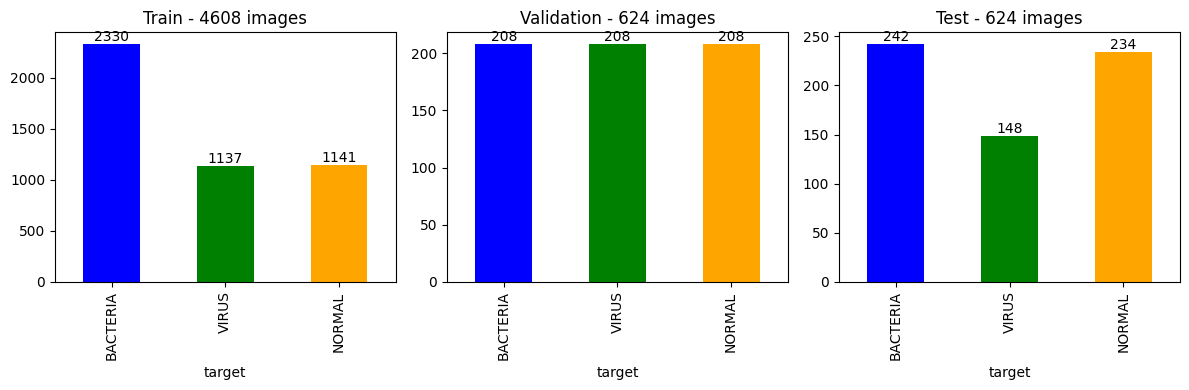

In [ ]:
show_classes_counts(train_df,val_df,test_df) # Show after update

In [ ]:
# Update the dataframes
train_df=create_df(train_dir)
val_df=create_df(val_dir)
test_df=create_df(test_dir)

## Change images size and mode

In [ ]:
# Creates new folders for the data
main_dir = 'data'
sub_dirs = ['train', 'val', 'test']
class_names = ['NORMAL', 'VIRUS','BACTERIA']

for sub_dir in sub_dirs:
    dir_path = os.path.join(main_dir, sub_dir)
    os.makedirs(dir_path, exist_ok=True)

    for class_name in class_names:
        class_dir_path = os.path.join(dir_path, class_name)
        os.makedirs(class_dir_path, exist_ok=True)


In [ ]:
# Define the new size of images for resize
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [ ]:
# Function to convert image mode in case it is not RGB
def check_mode(img):
  if img.mode!="RGB":
      img = img.convert("RGB")
  return img

# Function gets images from one directory and resize it and changes its mode to RGB if needed
# The images are saved in other directory
def resize_reshape_images(files,new_dir):
  for img_path in files:
    img = Image.open(img_path)
    img=check_mode(img)
    resized_img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    resized_img.save(os.path.join(new_dir, os.path.basename(img_path)))


In [ ]:
# Resize images and change image mode if needed, and save it to new folders
dfs=[train_df,val_df,test_df]
for i in range(len(sub_dirs)): # sub_dirs is 'train', 'val', 'test'
  for class_name in class_names: # class_names is 'NORMAL', 'VIRUS','BACTERIA'
    new_dir=get_dir_path('data',sub_dirs[i],class_name)
    print(f'new_dir:{new_dir}\n')
    files = dfs[i][dfs[i]['target'] == class_name]['filepath'].to_list()
    resize_reshape_images(files,new_dir)

new_dir:/raid/shelly_daniela/data/train/NORMAL

new_dir:/raid/shelly_daniela/data/train/VIRUS

new_dir:/raid/shelly_daniela/data/train/BACTERIA

new_dir:/raid/shelly_daniela/data/val/NORMAL

new_dir:/raid/shelly_daniela/data/val/VIRUS

new_dir:/raid/shelly_daniela/data/val/BACTERIA

new_dir:/raid/shelly_daniela/data/test/NORMAL

new_dir:/raid/shelly_daniela/data/test/VIRUS

new_dir:/raid/shelly_daniela/data/test/BACTERIA



In [ ]:
# Get new paths of folders
train_dir=get_dir_path('data','train')
val_dir=get_dir_path('data','val')
test_dir=get_dir_path('data','test')


## Data augmentation

In [ ]:
# Function returns how many images we need to add to a class in order to get a balanced data
# In Bacteria class there are the highest amount of images, so we use it to calculate the number of images we need
def get_difference(df,class_name):
  return df['target'].value_counts()['BACTERIA'] - df['target'].value_counts()[class_name]

In [ ]:
# Define parameters for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.08,
    horizontal_flip=False,
    vertical_flip=False,
    shear_range=0.02,
)

train_NORMAL_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='training',
    classes=['NORMAL'],
    save_to_dir=train_dir+'/NORMAL',
    save_prefix='augmentation_normal',
    save_format='jpeg',
)


train_VIRUS_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='training',
    classes=['VIRUS'],
    save_to_dir=train_dir+'/VIRUS',
    save_prefix='augmentation_virus',
    save_format='jpeg',
)

Found 1141 images belonging to 1 classes.
Found 1137 images belonging to 1 classes.


In [ ]:
# Function do data augmentation and saves few images of augmentation to show it
def activate_augmentation(df,generator,class_name):
  aug_imgs=[]
  num_of_imgs=get_difference(df,class_name)
  for i in range(num_of_imgs):
    batch_images, batch_labels = next(generator)
    if len(aug_imgs)<4:
      aug_imgs.append(batch_images[0])
  return aug_imgs

In [ ]:
aug_imgs_NORMAL=activate_augmentation(train_df,train_NORMAL_generator,'NORMAL') # Data augmentation for NORMAL class

In [ ]:
aug_imgs_VIRUS=activate_augmentation(train_df,train_VIRUS_generator,'VIRUS') # Data augmentation for VIRUS class

In [ ]:
# Show the images of data augmentation
def plot_aug_images(aug_imgs):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
  for i, ax in enumerate(axes.flat):
      ax.imshow(aug_imgs[i])
      ax.set_xticks([])
      ax.set_yticks([])


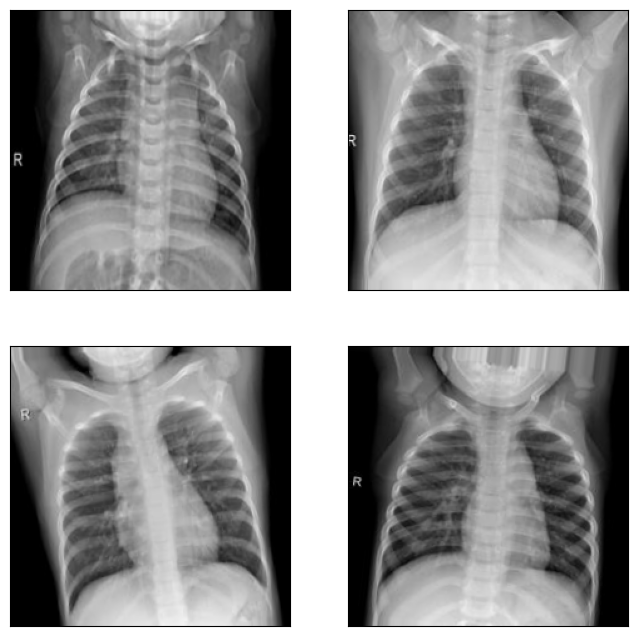

In [ ]:
plot_aug_images(aug_imgs_NORMAL)

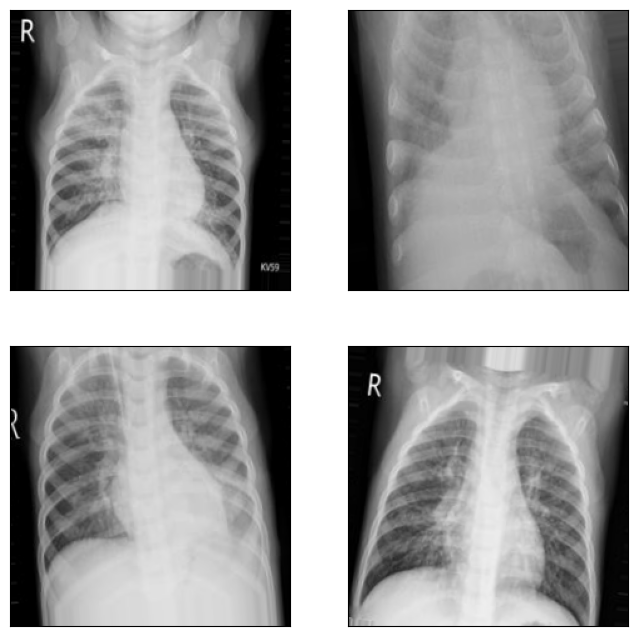

In [ ]:
plot_aug_images(aug_imgs_VIRUS)

Updating the data after augmentation

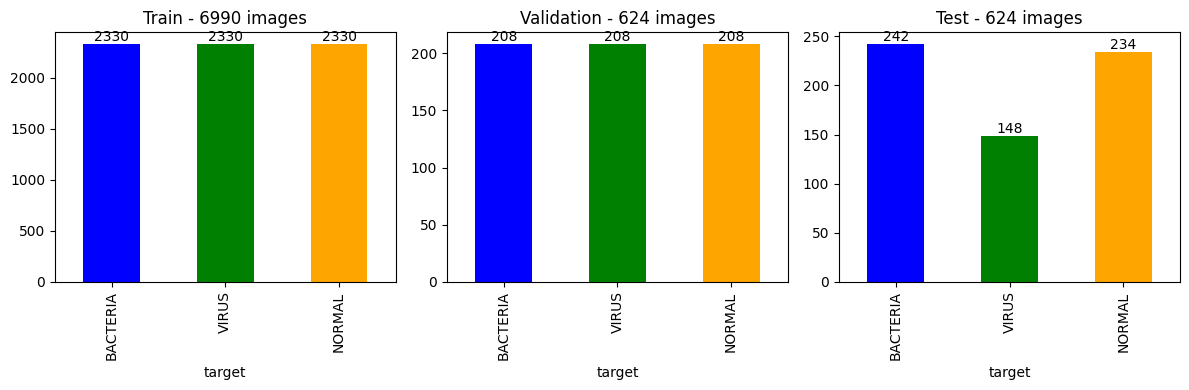

In [ ]:
train_df=create_df(train_dir)
val_df=create_df(val_dir)
test_df=create_df(test_dir)
show_classes_counts(train_df,val_df,test_df)

Prepare data for the model

In [ ]:
# Prepare the data: Normalization and change targets
def prepare_data(df):
  df['image_array'] = [np.array(Image.open(df['filepath'][i])) for i in range(len(df))]
  for i in range(len(df)):
    if 'augmentation' not in df['filepath'][i]: # images of augmentation were already rescaled
      df['image_array'][i] = df['image_array'][i] / 255.0
  df['target'] = df['target'].replace({'NORMAL': 0, 'BACTERIA': 1, 'VIRUS':2})
  num_classes = 3
  df['target'] = df['target'].apply(lambda x: np.array([1 if i == x else 0 for i in range(num_classes)])) # For one hot encoding

prepare_data(train_df)
prepare_data(val_df)
prepare_data(test_df)

In [ ]:
train_df.head()

,filepath,target,image_array
0,/raid/shelly_daniela/data/train/NORMAL/IM-0115...,"[1, 0, 0]","[[[0.07450980392156863, 0.07450980392156863, 0..."
1,/raid/shelly_daniela/data/train/NORMAL/IM-0117...,"[1, 0, 0]","[[[0.06274509803921569, 0.06274509803921569, 0..."
2,/raid/shelly_daniela/data/train/NORMAL/IM-0119...,"[1, 0, 0]","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,/raid/shelly_daniela/data/train/NORMAL/IM-0122...,"[1, 0, 0]","[[[0.1607843137254902, 0.1607843137254902, 0.1..."
4,/raid/shelly_daniela/data/train/NORMAL/IM-0125...,"[1, 0, 0]","[[[0.28627450980392155, 0.28627450980392155, 0..."


In [ ]:
# Flatten the nested lists in the 'image_array' column
train_images = np.concatenate(train_df['image_array'].to_numpy()).reshape(-1, 224, 224, 3)
val_images = np.concatenate(val_df['image_array'].to_numpy()).reshape(-1, 224, 224, 3)

# Convert to TensorFlow tensors and float32 data type
train_images = tf.convert_to_tensor(train_images.astype('float32'))
val_images = tf.convert_to_tensor(val_images.astype('float32'))

# Convert the target labels to one-hot encoded format
train_labels = np.stack(train_df['target'].to_numpy())
val_labels = np.stack(val_df['target'].to_numpy())


2023-07-17 17:54:35.763564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38247 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:37:00.0, compute capability: 8.0


In [ ]:
# Shows a graph of the accuracy of train and validation in each epoch
def show_model_results(history):
    train_acc = history.history['accuracy']
    validation_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, label="Training accuracy")
    plt.plot(epochs, validation_acc, label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

## Model 1

In [ ]:
# Define the model architecture
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 50468227 (192.52 MB)
Trainable params: 50468227 (192.52 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [ ]:
# Train the model
history1 = model1.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels))


Epoch 1/15


2023-07-17 17:54:44.328445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-17 17:54:44.963428: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-17 17:54:45.083664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-17 17:54:45.086036: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd05a99d710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-17 17:54:45.086052: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-07-17 17:54:45.090845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-17 17:54:45.150208:

219/219 [==============================] - 7s 17ms/step - loss: 197.7851 - accuracy: 0.6582 - val_loss: 0.6220 - val_accuracy: 0.7292
Epoch 2/15
219/219 [==============================] - 3s 15ms/step - loss: 0.6753 - accuracy: 0.8306 - val_loss: 0.5554 - val_accuracy: 0.7484
Epoch 3/15
219/219 [==============================] - 4s 17ms/step - loss: 0.4256 - accuracy: 0.8632 - val_loss: 0.5058 - val_accuracy: 0.7740
Epoch 4/15
219/219 [==============================] - 4s 18ms/step - loss: 0.3322 - accuracy: 0.8773 - val_loss: 0.4811 - val_accuracy: 0.7740
Epoch 5/15
219/219 [==============================] - 4s 18ms/step - loss: 0.2992 - accuracy: 0.8931 - val_loss: 0.4651 - val_accuracy: 0.7804
Epoch 6/15
219/219 [==============================] - 4s 16ms/step - loss: 0.5505 - accuracy: 0.8758 - val_loss: 0.5381 - val_accuracy: 0.7516
Epoch 7/15
219/219 [==============================] - 4s 18ms/step - loss: 0.4188 - accuracy: 0.8903 - val_loss: 0.6358 - val_accuracy: 0.7115
Epoch 8/

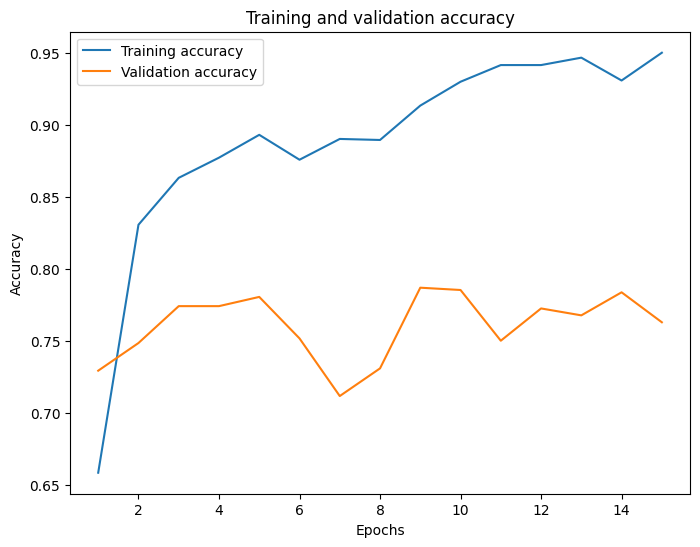

In [ ]:
show_model_results(history1)

## Model 2

In [ ]:
# Define the model architecture
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 387200)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               49561728  
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 49564547 (189.07 MB)
Trainable params: 49564547 (189.07 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
# Train the model
history2 = model2.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels))

Epoch 1/15
219/219 [==============================] - 5s 18ms/step - loss: 75.3344 - accuracy: 0.6432 - val_loss: 0.8196 - val_accuracy: 0.6651
Epoch 2/15
219/219 [==============================] - 4s 17ms/step - loss: 0.6010 - accuracy: 0.7894 - val_loss: 0.6714 - val_accuracy: 0.6795
Epoch 3/15
219/219 [==============================] - 3s 16ms/step - loss: 0.4143 - accuracy: 0.8333 - val_loss: 0.5420 - val_accuracy: 0.7484
Epoch 4/15
219/219 [==============================] - 3s 16ms/step - loss: 0.3497 - accuracy: 0.8526 - val_loss: 0.5678 - val_accuracy: 0.7468
Epoch 5/15
219/219 [==============================] - 4s 16ms/step - loss: 0.3397 - accuracy: 0.8660 - val_loss: 0.7310 - val_accuracy: 0.6795
Epoch 6/15
219/219 [==============================] - 4s 19ms/step - loss: 0.3019 - accuracy: 0.8781 - val_loss: 0.8436 - val_accuracy: 0.6554
Epoch 7/15
219/219 [==============================] - 4s 16ms/step - loss: 0.2628 - accuracy: 0.8894 - val_loss: 0.4845 - val_accuracy: 0.791

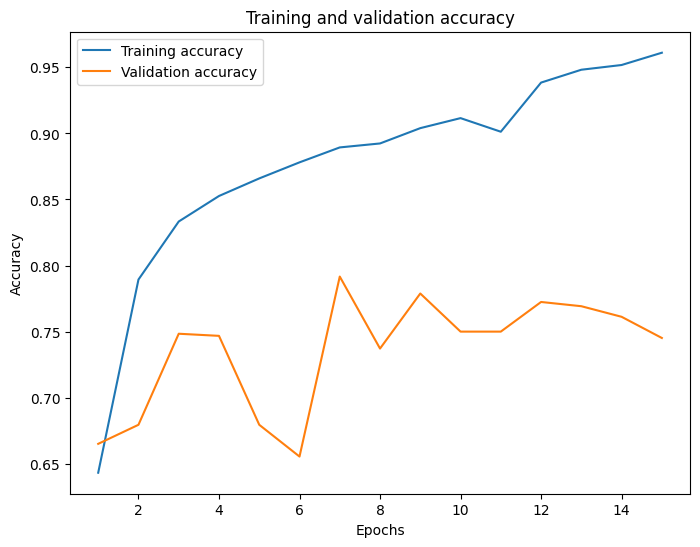

In [ ]:
show_model_results(history2)

## Model 3

In [ ]:
# Define the model architecture
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 394272)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               50466944  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                      

In [ ]:
# Train the model
history3 = model3.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels))

Epoch 1/15
219/219 [==============================] - 5s 16ms/step - loss: 130.9405 - accuracy: 0.3657 - val_loss: 1.0513 - val_accuracy: 0.4519
Epoch 2/15
219/219 [==============================] - 3s 15ms/step - loss: 1.0292 - accuracy: 0.4840 - val_loss: 0.8832 - val_accuracy: 0.6699
Epoch 3/15
219/219 [==============================] - 4s 16ms/step - loss: 0.8092 - accuracy: 0.5908 - val_loss: 0.7366 - val_accuracy: 0.7035
Epoch 4/15
219/219 [==============================] - 4s 17ms/step - loss: 0.7552 - accuracy: 0.6449 - val_loss: 0.7694 - val_accuracy: 0.7083
Epoch 5/15
219/219 [==============================] - 4s 17ms/step - loss: 0.6825 - accuracy: 0.6897 - val_loss: 0.6847 - val_accuracy: 0.7420
Epoch 6/15
219/219 [==============================] - 3s 16ms/step - loss: 0.6389 - accuracy: 0.7182 - val_loss: 0.6545 - val_accuracy: 0.7131
Epoch 7/15
219/219 [==============================] - 3s 15ms/step - loss: 0.6279 - accuracy: 0.7096 - val_loss: 0.5952 - val_accuracy: 0.73

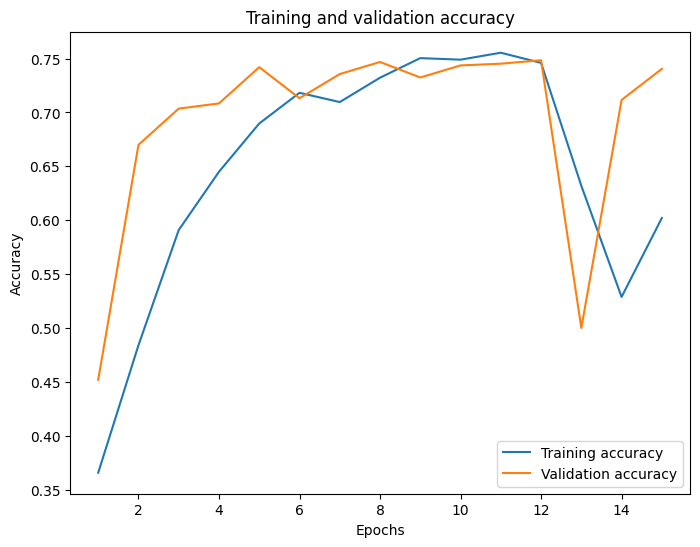

In [ ]:
show_model_results(history3)

## Model 4

In [ ]:
# Define the model architecture
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=tf.keras.regularizers.l1(0.0005)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0005)),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 394272)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               50466944  
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 50468227 (192.52 MB)
Trainable params: 50468227 (192.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
# Train the model
history4 = model4.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels))

Epoch 1/15
219/219 [==============================] - 5s 17ms/step - loss: 176.1802 - accuracy: 0.5698 - val_loss: 44.9059 - val_accuracy: 0.3718
Epoch 2/15
219/219 [==============================] - 3s 16ms/step - loss: 35.1606 - accuracy: 0.6774 - val_loss: 27.6047 - val_accuracy: 0.3894
Epoch 3/15
219/219 [==============================] - 4s 16ms/step - loss: 22.6077 - accuracy: 0.7166 - val_loss: 18.8918 - val_accuracy: 0.4407
Epoch 4/15
219/219 [==============================] - 4s 21ms/step - loss: 15.9252 - accuracy: 0.7310 - val_loss: 13.7572 - val_accuracy: 0.6795
Epoch 5/15
219/219 [==============================] - 3s 16ms/step - loss: 11.7106 - accuracy: 0.7634 - val_loss: 10.0992 - val_accuracy: 0.5897
Epoch 6/15
219/219 [==============================] - 3s 16ms/step - loss: 8.6904 - accuracy: 0.7777 - val_loss: 7.7098 - val_accuracy: 0.7292
Epoch 7/15
219/219 [==============================] - 3s 15ms/step - loss: 7.1949 - accuracy: 0.7918 - val_loss: 6.8009 - val_accur

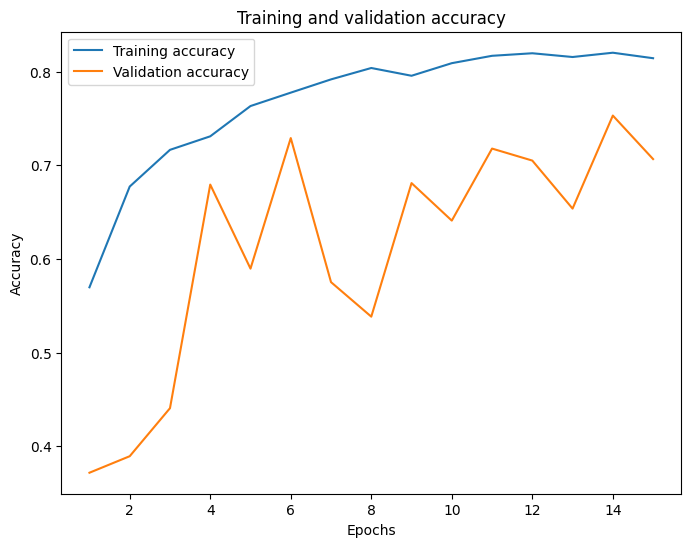

In [ ]:
show_model_results(history4)

## Model 5

In [ ]:
# Define the model architecture
model5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 394272)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               50466944  
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 50468227 (192.52 MB)
Trainable params: 50468227 (192.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
# Train the model
history5 = model5.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels))

Epoch 1/15
219/219 [==============================] - 5s 18ms/step - loss: 51.2639 - accuracy: 0.6522 - val_loss: 1.2171 - val_accuracy: 0.6795
Epoch 2/15
219/219 [==============================] - 5s 22ms/step - loss: 1.0397 - accuracy: 0.7811 - val_loss: 1.1074 - val_accuracy: 0.6939
Epoch 3/15
219/219 [==============================] - 4s 16ms/step - loss: 0.8888 - accuracy: 0.8104 - val_loss: 1.0308 - val_accuracy: 0.7163
Epoch 4/15
219/219 [==============================] - 4s 17ms/step - loss: 0.7984 - accuracy: 0.8300 - val_loss: 0.9384 - val_accuracy: 0.7388
Epoch 5/15
219/219 [==============================] - 4s 17ms/step - loss: 0.7613 - accuracy: 0.8365 - val_loss: 0.8703 - val_accuracy: 0.7596
Epoch 6/15
219/219 [==============================] - 3s 15ms/step - loss: 0.6922 - accuracy: 0.8469 - val_loss: 0.8967 - val_accuracy: 0.7179
Epoch 7/15
219/219 [==============================] - 4s 16ms/step - loss: 0.7369 - accuracy: 0.8466 - val_loss: 0.9314 - val_accuracy: 0.734

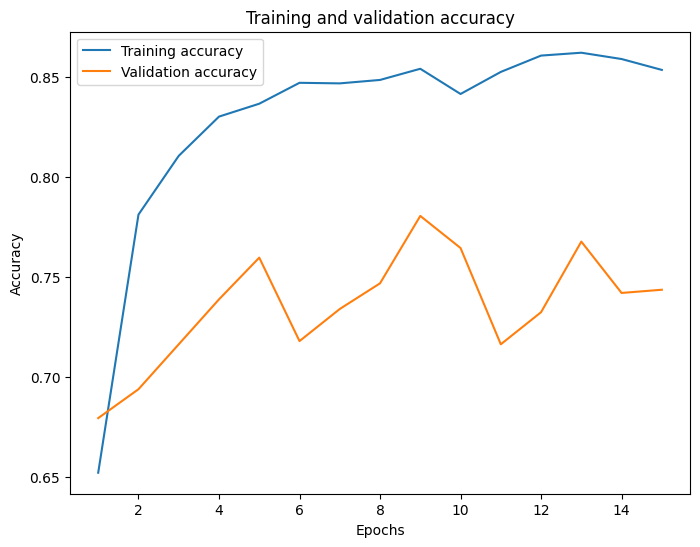

In [ ]:
show_model_results(history5)

## Model 6

In [ ]:
# Define the model architecture
model6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 186624)            0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [ ]:
# Train the model
history6 = model6.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels))

Epoch 1/15
219/219 [==============================] - 5s 18ms/step - loss: 22.0461 - accuracy: 0.6247 - val_loss: 0.7191 - val_accuracy: 0.6731
Epoch 2/15
219/219 [==============================] - 4s 17ms/step - loss: 0.5514 - accuracy: 0.7745 - val_loss: 0.5936 - val_accuracy: 0.7051
Epoch 3/15
219/219 [==============================] - 4s 17ms/step - loss: 0.4822 - accuracy: 0.7989 - val_loss: 0.5882 - val_accuracy: 0.7212
Epoch 4/15
219/219 [==============================] - 4s 17ms/step - loss: 0.4309 - accuracy: 0.8192 - val_loss: 0.5593 - val_accuracy: 0.7244
Epoch 5/15
219/219 [==============================] - 4s 16ms/step - loss: 0.4106 - accuracy: 0.8237 - val_loss: 0.5655 - val_accuracy: 0.7388
Epoch 6/15
219/219 [==============================] - 4s 17ms/step - loss: 0.3859 - accuracy: 0.8340 - val_loss: 0.5271 - val_accuracy: 0.7564
Epoch 7/15
219/219 [==============================] - 4s 17ms/step - loss: 0.3641 - accuracy: 0.8435 - val_loss: 0.5411 - val_accuracy: 0.751

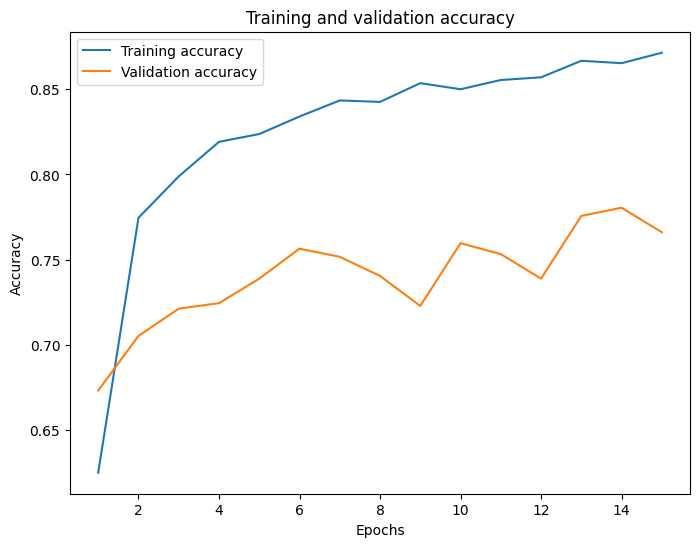

In [ ]:
show_model_results(history6)

## Model 8

In [ ]:
num_classes=3 # We have 3 classes

# Define the ResNet-50 model without the top classification layers
# include_top=False: not include the fully-connected layer at the top of the network.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers so they won't be updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output) # GlobalAveragePooling2D is a type of pooling layer
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # 'num_classes' is the number of classes in your data

# Create the final model
model8 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 32
history8 = model8.fit(train_images, train_labels, batch_size=batch_size, epochs=30, validation_data=(val_images, val_labels))


Epoch 1/30
219/219 [==============================] - 9s 31ms/step - loss: 0.7670 - accuracy: 0.6413 - val_loss: 1.0635 - val_accuracy: 0.4071
Epoch 2/30
219/219 [==============================] - 6s 28ms/step - loss: 0.6454 - accuracy: 0.7087 - val_loss: 0.9582 - val_accuracy: 0.5112
Epoch 3/30
219/219 [==============================] - 6s 26ms/step - loss: 0.6020 - accuracy: 0.7280 - val_loss: 0.9327 - val_accuracy: 0.5304
Epoch 4/30
219/219 [==============================] - 6s 26ms/step - loss: 0.5899 - accuracy: 0.7373 - val_loss: 0.9571 - val_accuracy: 0.4968
Epoch 5/30
219/219 [==============================] - 6s 27ms/step - loss: 0.5638 - accuracy: 0.7466 - val_loss: 0.8325 - val_accuracy: 0.5705
Epoch 6/30
219/219 [==============================] - 6s 26ms/step - loss: 0.5502 - accuracy: 0.7525 - val_loss: 0.8589 - val_accuracy: 0.5641
Epoch 7/30
219/219 [==============================] - 6s 26ms/step - loss: 0.5388 - accuracy: 0.7522 - val_loss: 0.8414 - val_accuracy: 0.5769

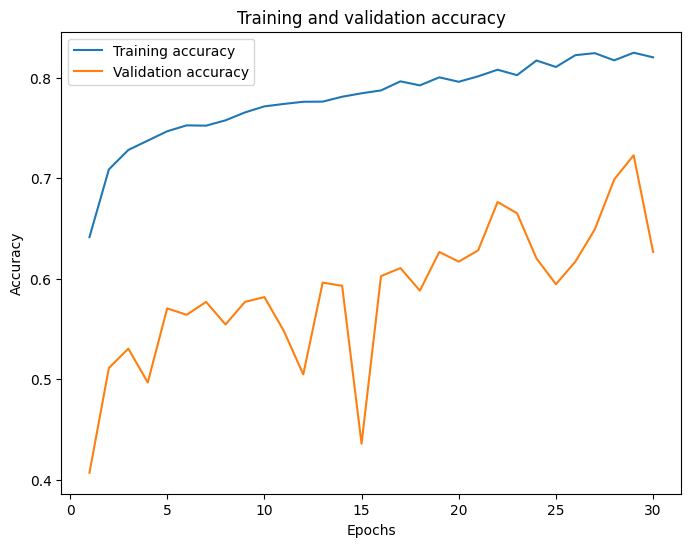

In [ ]:
show_model_results(history8)

## Prediction

We chose using model3 for prediction after checking and comparing the results of all models

In [ ]:
# Preprocess the test data
# Flatten the nested lists in the 'image_array' column
test_images = np.concatenate(test_df['image_array'].to_numpy()).reshape(-1, 224, 224, 3)

# Convert to TensorFlow tensors and float32 data type
test_images = tf.convert_to_tensor(test_images.astype('float32'))

# Convert the target labels to one-hot encoded format
test_labels = np.stack(test_df['target'].to_numpy())

# Use model3 to predict
predictions = model3.predict(test_images)

20/20 [==============================] - 0s 10ms/step


accuracy

In [ ]:
# Calculate accuracy
y_pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
accuracy = accuracy_score(true_labels, y_pred_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 60.42%


Confusion matrix

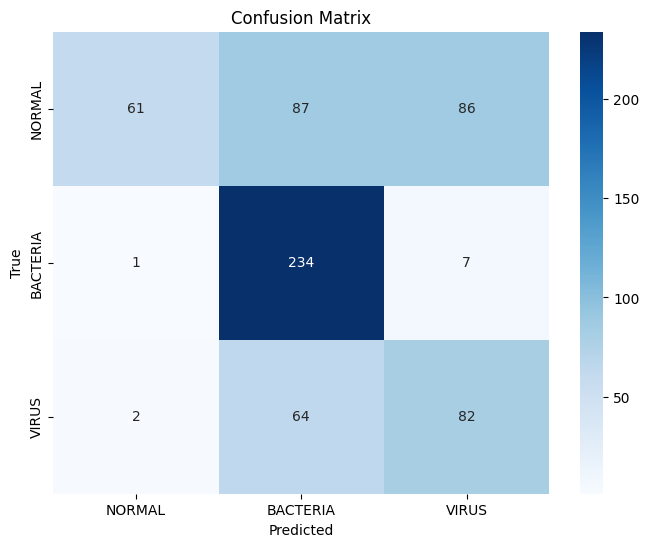

In [ ]:
cm = confusion_matrix(true_labels, y_pred_labels)

# Define class labels
class_labels = ['NORMAL', 'BACTERIA', 'VIRUS']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


ROC curve

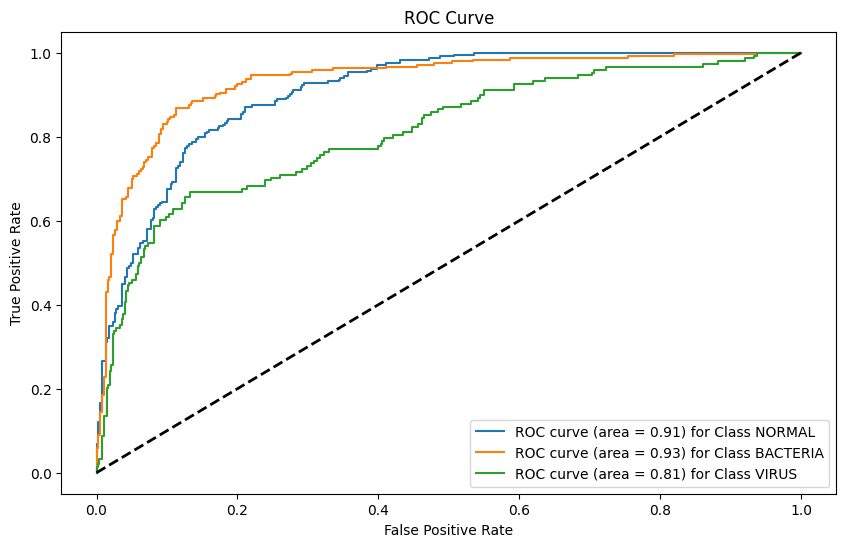

In [ ]:
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for Class {class_labels[i]}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
